# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Omitir todos los warnings
import warnings
warnings.filterwarnings('ignore')

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

# from modules import kmeans_module as km_m
# from modules import preprocessing_module as pm
from modules.get_data import get_data

# !pip install featuretools # install the missing module
# from modules import feature_creation_module as fcm

## Importacion datos

In [18]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df = get_data('daily_sales_with_events.csv') # Vamos a probar con diarias -> filtramos por años para que no pete la creacion de caracteristicas

In [19]:
# Seleccionar solo años 2014 a 2015 de df_s
df = df[(df['year'] >= 2014) & (df['year'] <= 2015)]

# Cambiamos NaN de event por None
df['event'] = df['event'].fillna('None')

display(df.shape)

(8217627, 12)

In [20]:
# Añadimos departament y category desde df_items a df usando la columna 'item'
df = pd.merge(df, df_items[['item', 'department', 'category']], on='item', how='left')

In [21]:
df_origin = df.copy() # Para recuperar df si hace falta

___
___

## Functions

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [8]:
SCALER = RobustScaler

In [9]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")

In [10]:
print('DONE')

DONE


# SIMPLE : SALES PERFORMANCE

## Copy data

In [22]:
df = df_origin.copy()
df.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event,department,category
0,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear,ACCESORIES_1,ACCESORIES
1,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear,ACCESORIES_1,ACCESORIES
2,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear,ACCESORIES_1,ACCESORIES
3,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear,ACCESORIES_1,ACCESORIES
4,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear,ACCESORIES_1,ACCESORIES


In [23]:
df_shops.head()

,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


## Global

In [24]:
# Añadimos columna region de df_shops a df
df_ = pd.merge(df, df_shops[['store_code', 'region']], on='store_code', how='left')

# Primero agrupamos por tienda y sumamos units y raw_earn conservando la columna region
df_ = df_.groupby(['store_code', 'region'])[['units', 'raw_earn']].sum().reset_index()

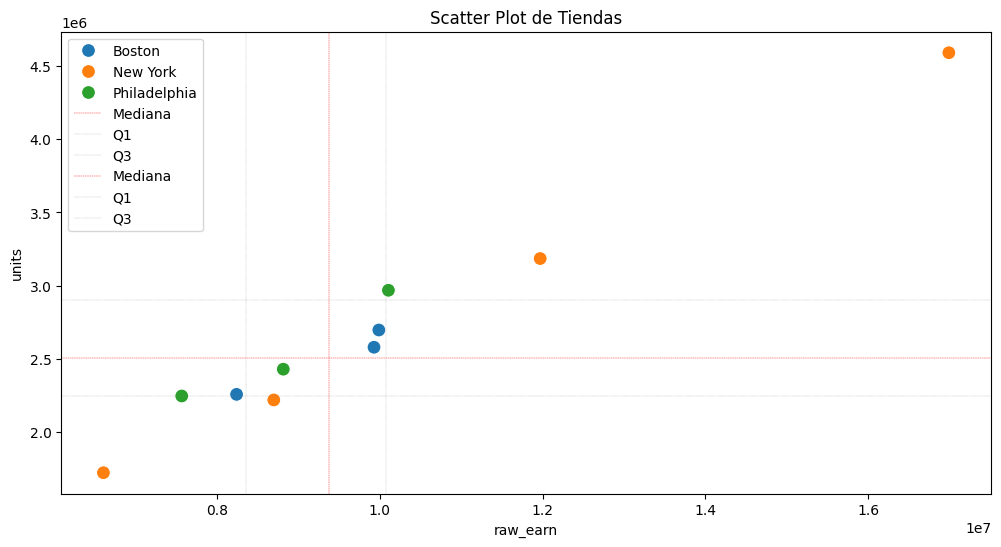

In [25]:
# Vemos scatter plot de df por tiendas: Eje y raw_earn, Eje x units y el color será region
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_, x="raw_earn", y="units", hue="region", s=100)
plt.title("Scatter Plot de Tiendas")

# Calcular mediana y cuartiles para 'raw_earn' y 'units'
x_median = df_['raw_earn'].median()
x_q1 = np.percentile(df_['raw_earn'], 25)
x_q3 = np.percentile(df_['raw_earn'], 75)

y_median = df_['units'].median()
y_q1 = np.percentile(df_['units'], 25)
y_q3 = np.percentile(df_['units'], 75)

# Agregar líneas horizontales y verticales
plt.axvline(x_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)
plt.axvline(x_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
plt.axvline(x_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

plt.axhline(y_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)
plt.axhline(y_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
plt.axhline(y_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

plt.legend(loc='upper left')  # Leyenda arriba a la izquierda
plt.show()

In [26]:
df_.head()

,store_code,region,units,raw_earn
0,BOS_1,Boston,2256815,8.240373e+06
1,BOS_2,Boston,2696579,9.988775e+06
2,BOS_3,Boston,2578744,9.928976e+06
3,NYC_1,New York,3184794,1.197108e+07
4,NYC_2,New York,2218634,8.697776e+06


In [27]:
# Hacer un clustering usando kmeans de 3 clusters usando units y raw_earn
df_to_scale = df_[['units', 'raw_earn']].copy()

cluster_data_scaled, scaler = preprocess_features(df_to_scale)

# Paso 5: Determinar el número óptimo de clusters
k_range = range(2, 9)

print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print('SILUETA')
silhouette_scores = []

for k in k_range:
    # kmeans = init_kmeans(k)
    kmeans = init_kmeans(k)
    kmeans.fit(cluster_data_scaled)
    silhouette_scores.append(silhouette_score(cluster_data_scaled, kmeans.labels_))

fig = px.line(
    x=k_range,
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
SILUETA


In [28]:
# Paso 6: Realizar el clustering con el número óptimo de clusters
optimal_k = 3  # Segun silueta seria 2 pero en el scatter plot podemos ver 3

# kmeans = init_kmeans(optimal_k)
kmeans = kmeans = KMeans(
    n_clusters=optimal_k,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42
    )

cluster_labels = kmeans.fit_predict(cluster_data_scaled)

# Añadir las etiquetas de cluster al DataFrame original
df_['cluster'] = cluster_labels

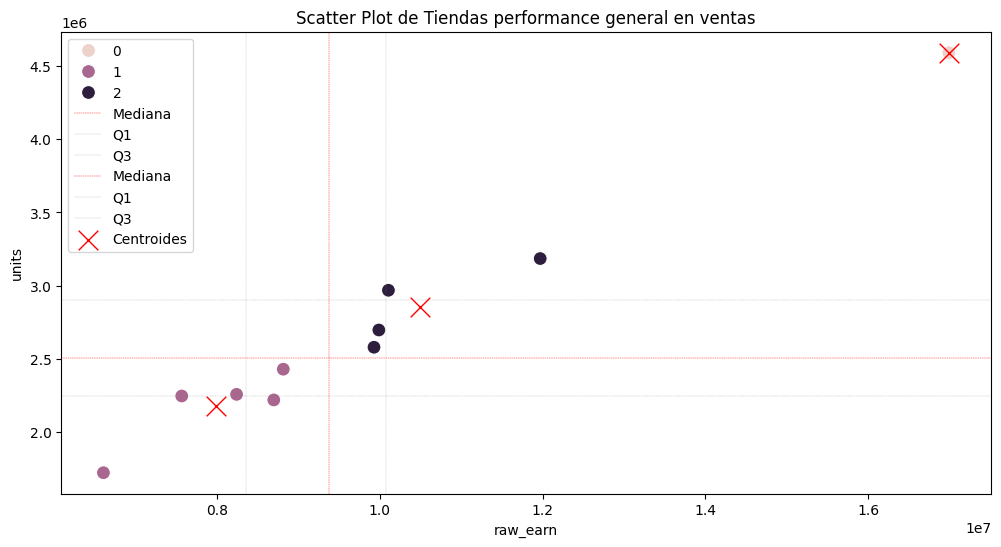

In [35]:
# Vemos scatter plot de df por tiendas: Eje y raw_earn, Eje x units y el color será cluster
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_, x="raw_earn", y="units", hue="cluster", s=100)
plt.title("Scatter Plot de Tiendas performance general en ventas")

# Calcular mediana y cuartiles para 'raw_earn' y 'units'
x_median = df_['raw_earn'].median()
x_q1 = np.percentile(df_['raw_earn'], 25)
x_q3 = np.percentile(df_['raw_earn'], 75)

y_median = df_['units'].median()
y_q1 = np.percentile(df_['units'], 25)
y_q3 = np.percentile(df_['units'], 75)

# Agregar líneas horizontales y verticales
plt.axvline(x_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)
plt.axvline(x_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
plt.axvline(x_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

plt.axhline(y_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)
plt.axhline(y_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
plt.axhline(y_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

# Agregar centroides al gráfico
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)
plt.scatter(centroids[:, 1], centroids[:, 0], marker='x', s=200, linewidths=1, color='red', label='Centroides')

plt.legend(loc='upper left')  # Leyenda arriba a la izquierda
plt.show()

## Categorias

In [36]:
# Ahora vamos a verlo pero por categoria
# Añadimos columna region de df_shops a df
df_ = pd.merge(df, df_shops[['store_code', 'region']], on='store_code', how='left')

# agrupamos por tienda y categoria sumando units y raw_earn conservando la columna region
df_ = df_.groupby(['store_code', 'region', 'category'])[['units', 'raw_earn']].sum().reset_index()

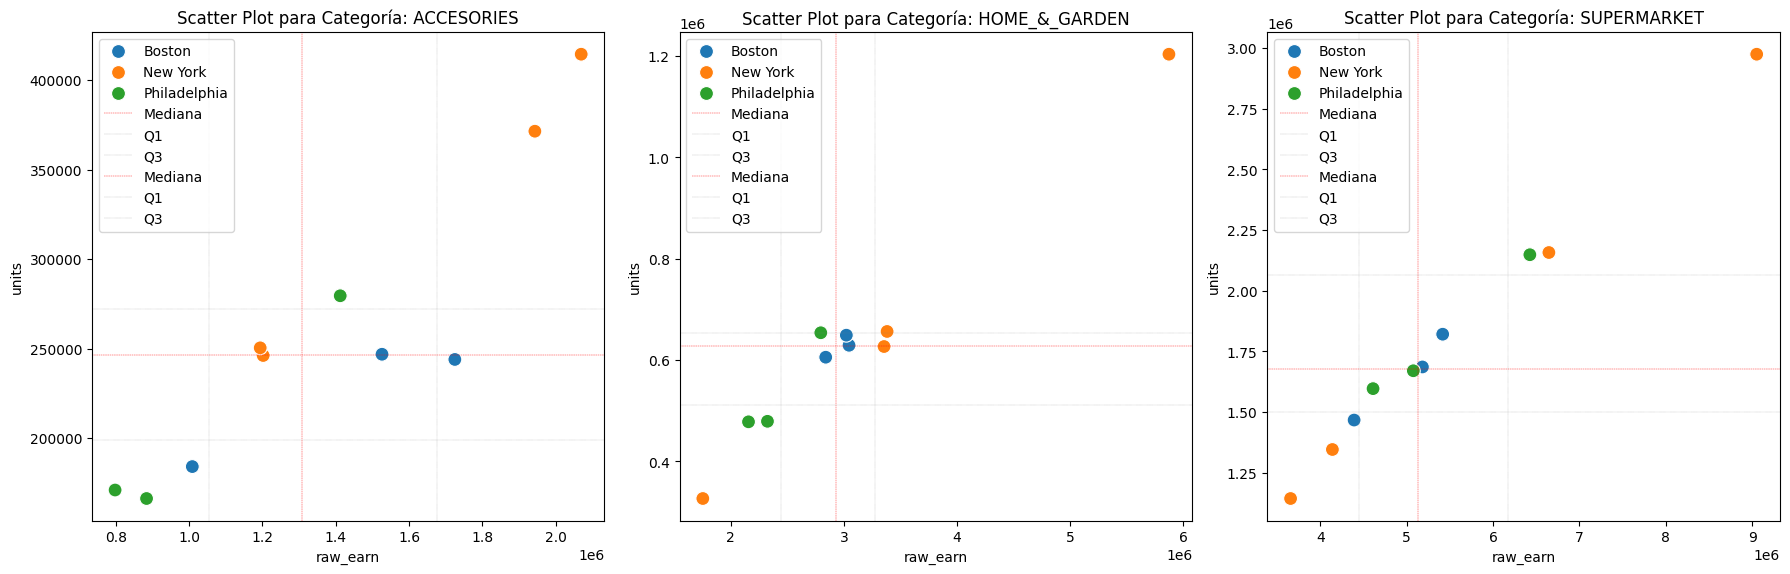

In [37]:
# Vemos scatter plot filtrando primero por categoria (un scatter plot por categoria)
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Obtener lista de categorías únicas
categorias = df_['category'].unique()

# Calcular el número de filas y columnas para la cuadrícula
num_cols = 3  # Número de columnas
num_rows = math.ceil(len(categorias) / num_cols)  # Número de filas (redondeado hacia arriba)

# Crear la figura y los subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
axes = axes.flatten()

# Iterar sobre las categorías y crear un scatter plot para cada una
for i, categoria in enumerate(categorias):
    data_categoria = df_[df_['category'] == categoria]

    # Crear scatter plot en el subplot correspondiente
    sns.scatterplot(data=data_categoria, x="raw_earn", y="units", hue="region", s=100, ax=axes[i])
    axes[i].set_title(f"Scatter Plot para Categoría: {categoria}")

    # Calcular mediana y cuartiles para 'raw_earn' y 'units'
    x_median = data_categoria['raw_earn'].median()
    # x_median = data_categoria['raw_earn'].mean()
    x_q1 = np.percentile(data_categoria['raw_earn'], 25)
    x_q3 = np.percentile(data_categoria['raw_earn'], 75)

    y_median = data_categoria['units'].median()
    # y_median = data_categoria['units'].mean()
    y_q1 = np.percentile(data_categoria['units'], 25)
    y_q3 = np.percentile(data_categoria['units'], 75)

    # Agregar líneas horizontales y verticales
    axes[i].axvline(x_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)  # Mediana en rojo
    axes[i].axvline(x_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
    axes[i].axvline(x_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

    axes[i].axhline(y_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)  # Mediana en rojo
    axes[i].axhline(y_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
    axes[i].axhline(y_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

    axes[i].legend(loc='upper left')  # Leyenda arriba a la izquierda

# Ocultar los subplots vacíos si los hay
for j in range(len(categorias), len(axes)):
    axes[j].set_visible(False)

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [52]:
# Hacer un clustering usando kmeans de 3 clusters usando units y raw_earn
def silueta_categoria(data):
  df_to_scale = data[['units', 'raw_earn']].copy()

  cluster_data_scaled, scaler = preprocess_features(df_to_scale)

  # Paso 5: Determinar el número óptimo de clusters
  k_range = range(2, 9)

  print('SILUETA')
  silhouette_scores = []

  for k in k_range:
      # kmeans = init_kmeans(k)
      kmeans = init_kmeans(k)
      kmeans.fit(cluster_data_scaled)
      silhouette_scores.append(silhouette_score(cluster_data_scaled, kmeans.labels_))

  fig = px.line(
      x=k_range,
      y=silhouette_scores,
      title="Silhouette score",
      labels={"x": "k", "y": "Silhouette score"},
  )
  fig.show()

In [ ]:
# Filtramos df_ por categoria y llamamos a funcion silueta_categoria pasando el df obtenido
# Obtenemos una lista con los valores unicos de la columna category
cats = df_['category'].unique().tolist()
print(cats)

for cat in cats:
  d = df_[df_['category'] == cat]
  print(f'Categoria: {cat}')
  d_scaled, scaler = preprocess_features(d[['units', 'raw_earn']])
  silueta_categoria(d_scaled)
  print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')

['ACCESORIES', 'HOME_&_GARDEN', 'SUPERMARKET']
Categoria: ACCESORIES
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Categoria: HOME_&_GARDEN
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Categoria: SUPERMARKET
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [45]:
def k_means_categoria(data_scaled, data_origin, optimal_k):
  # Paso 6: Realizar el clustering con el número óptimo de clusters
  # kmeans = init_kmeans(optimal_k)
  kmeans = kmeans = KMeans(
      n_clusters=optimal_k,
      init='k-means++',
      n_init=10,
      max_iter=300,
      random_state=42
      )

  cluster_labels = kmeans.fit_predict(data_scaled)
  centroids = kmeans.cluster_centers_

  # Añadir las etiquetas de cluster al DataFrame original
  data_scaled['cluster'] = cluster_labels
  data_origin['cluster'] = cluster_labels

  return data_scaled, centroids, data_origin, kmeans

In [43]:
def plot_kmeans_category(data, cat, kmeans):
  # Vemos scatter plot de df por tiendas: Eje y raw_earn, Eje x units y el color será cluster
  plt.figure(figsize=(12, 6))
  sns.scatterplot(data=data, x="raw_earn", y="units", hue="cluster", s=100)
  plt.title(f"Scatter Plot de Tiendas performance ventas por {cat}")

  # Calcular mediana y cuartiles para 'raw_earn' y 'units'
  x_median = data['raw_earn'].median()
  x_q1 = np.percentile(data['raw_earn'], 25)
  x_q3 = np.percentile(data['raw_earn'], 75)

  y_median = data['units'].median()
  y_q1 = np.percentile(data['units'], 25)
  y_q3 = np.percentile(data['units'], 75)

  # Agregar líneas horizontales y verticales
  plt.axvline(x_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)
  plt.axvline(x_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
  plt.axvline(x_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

  plt.axhline(y_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)
  plt.axhline(y_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
  plt.axhline(y_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

  # Agregar centroides al gráfico
  centroids = kmeans.cluster_centers_
  centroids = scaler.inverse_transform(centroids)
  plt.scatter(centroids[:, 1], centroids[:, 0], marker='x', s=200, linewidths=1, color='red', label='Centroides')

  plt.legend(loc='upper left')  # Leyenda arriba a la izquierda
  plt.show()

Categoria: ACCESORIES


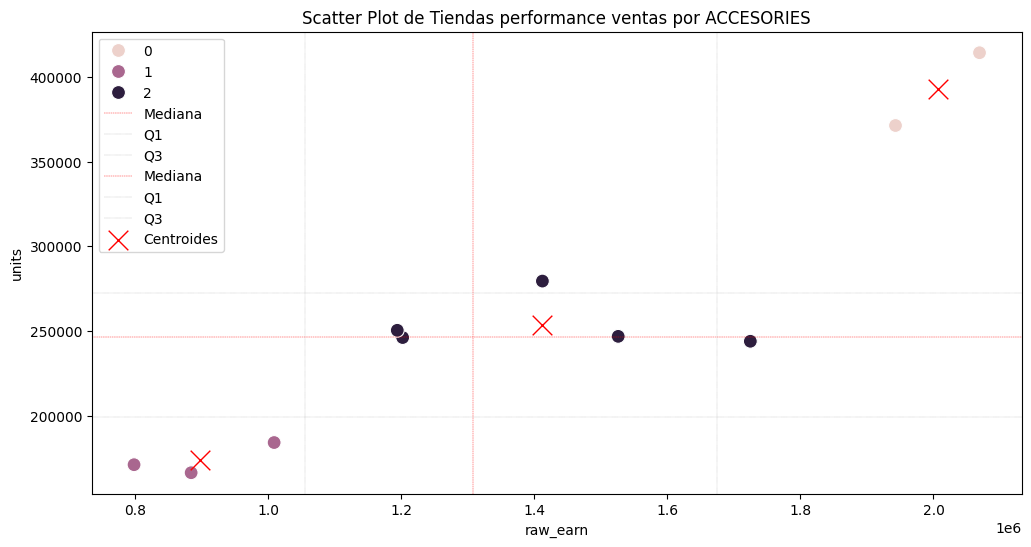

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Categoria: HOME_&_GARDEN


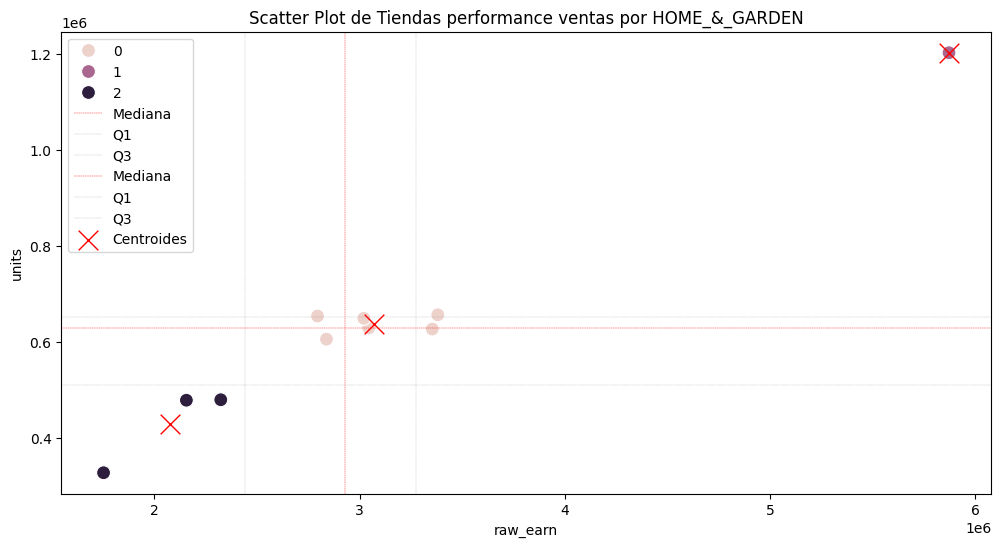

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Categoria: SUPERMARKET


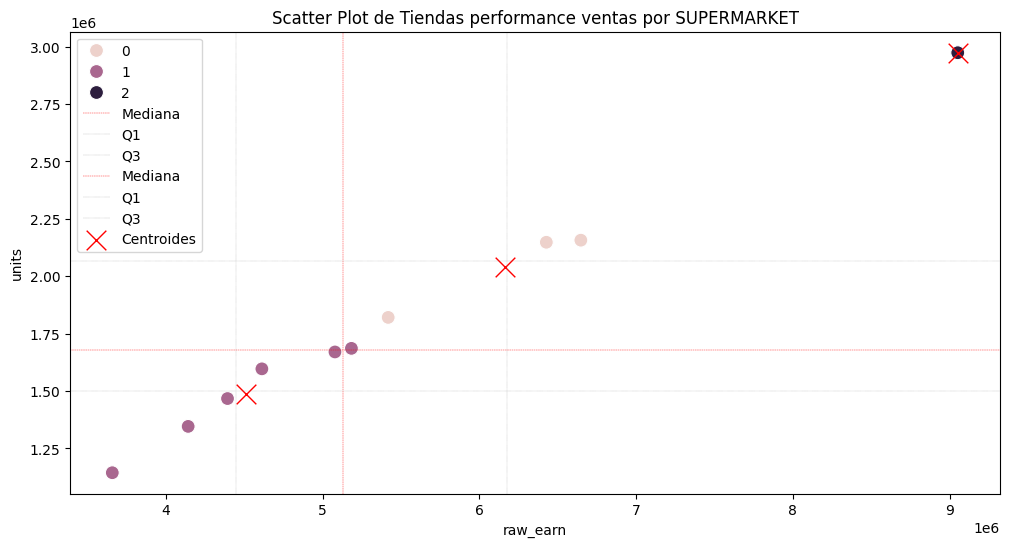

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [46]:
cats = df_['category'].unique().tolist()
optimal_k = 3

for cat in cats:
  d = df_[df_['category'] == cat]
  print(f'Categoria: {cat}')
  d_scaled, scaler = preprocess_features(d[['units', 'raw_earn']])
  d_scaled, centroids, data_origin, model = k_means_categoria(d_scaled, d, optimal_k)
  plot_kmeans_category(data_origin, cat, model)
  print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
  sales_impact(data_origin, 'category', df_)

## Departamentos

In [48]:
# Ahora vamos a verlo pero por departamentos
# Añadimos columna region de df_shops a df
df_ = pd.merge(df, df_shops[['store_code', 'region']], on='store_code', how='left')

# agrupamos por tienda y departamento sumando units y raw_earn conservando la columna region
df_ = df_.groupby(['store_code', 'region', 'department'])[['units', 'raw_earn']].sum().reset_index()

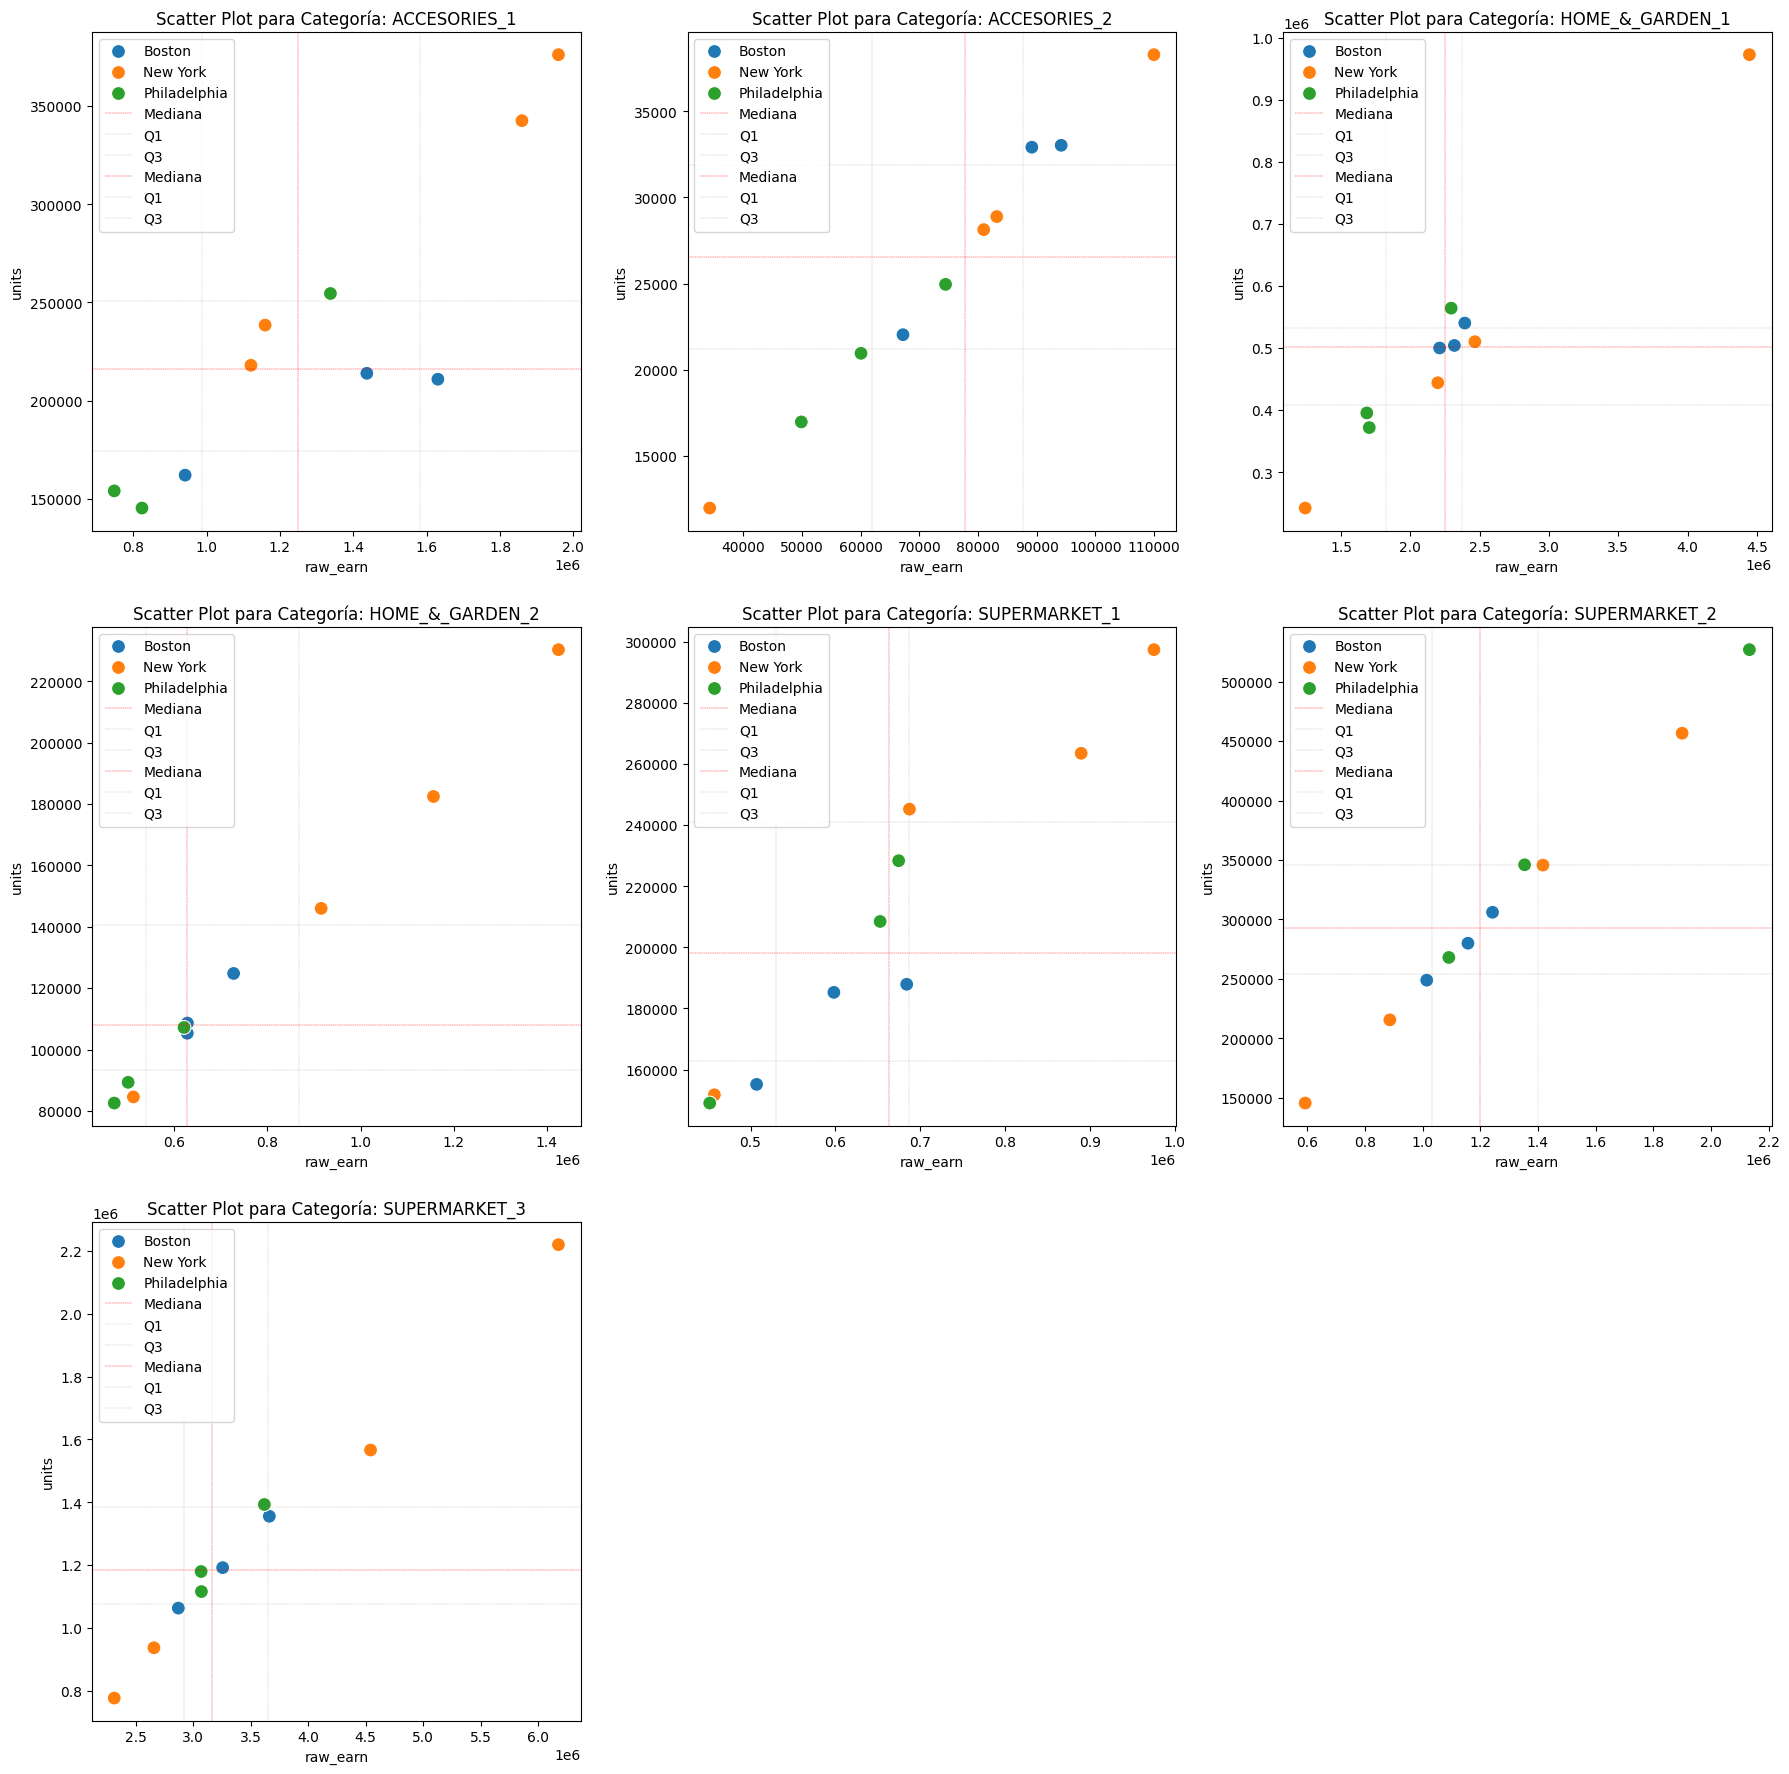

In [50]:
# Vemos scatter plot filtrando primero por departamento

# Obtener lista de categorías únicas
departments = df_['department'].unique()

# Calcular el número de filas y columnas para la cuadrícula
num_cols = 3  # Número de columnas
num_rows = math.ceil(len(departments) / num_cols)  # Número de filas (redondeado hacia arriba)

# Crear la figura y los subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
axes = axes.flatten()

# Iterar sobre las departamentos y crear un scatter plot para cada una
for i, department in enumerate(departments):
    data_department = df_[df_['department'] == department]

    # Crear scatter plot en el subplot correspondiente
    sns.scatterplot(data=data_department, x="raw_earn", y="units", hue="region", s=100, ax=axes[i])
    axes[i].set_title(f"Scatter Plot para departamento: {department}")

    # Calcular mediana y cuartiles para 'raw_earn' y 'units'
    x_median = data_department['raw_earn'].median()
    # x_median = data_department['raw_earn'].mean()
    x_q1 = np.percentile(data_department['raw_earn'], 25)
    x_q3 = np.percentile(data_department['raw_earn'], 75)

    y_median = data_department['units'].median()
    # y_median = data_department['units'].mean()
    y_q1 = np.percentile(data_department['units'], 25)
    y_q3 = np.percentile(data_department['units'], 75)

    # Agregar líneas horizontales y verticales
    axes[i].axvline(x_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)  # Mediana en rojo
    axes[i].axvline(x_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
    axes[i].axvline(x_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

    axes[i].axhline(y_median, color='red', linestyle='--', label='Mediana', linewidth=0.3)  # Mediana en rojo
    axes[i].axhline(y_q1, color='gray', linestyle=':', label='Q1', linewidth=0.3)
    axes[i].axhline(y_q3, color='gray', linestyle=':', label='Q3', linewidth=0.3)

    axes[i].legend(loc='upper left')  # Leyenda arriba a la izquierda

# Ocultar los subplots vacíos si los hay
for j in range(len(departments), len(axes)):
    axes[j].set_visible(False)

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [53]:
depts = df_['department'].unique().tolist()

for dept in depts:
  d = df_[df_['department'] == dept]
  print(f'department: {dept}')
  d_scaled, scaler = preprocess_features(d[['units', 'raw_earn']])
  silueta_categoria(d_scaled)
  print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')

department: ACCESORIES_1
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
department: ACCESORIES_2
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
department: HOME_&_GARDEN_1
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
department: HOME_&_GARDEN_2
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
department: SUPERMARKET_1
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
department: SUPERMARKET_2
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
department: SUPERMARKET_3
SILUETA


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Departamento: ACCESORIES_1
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


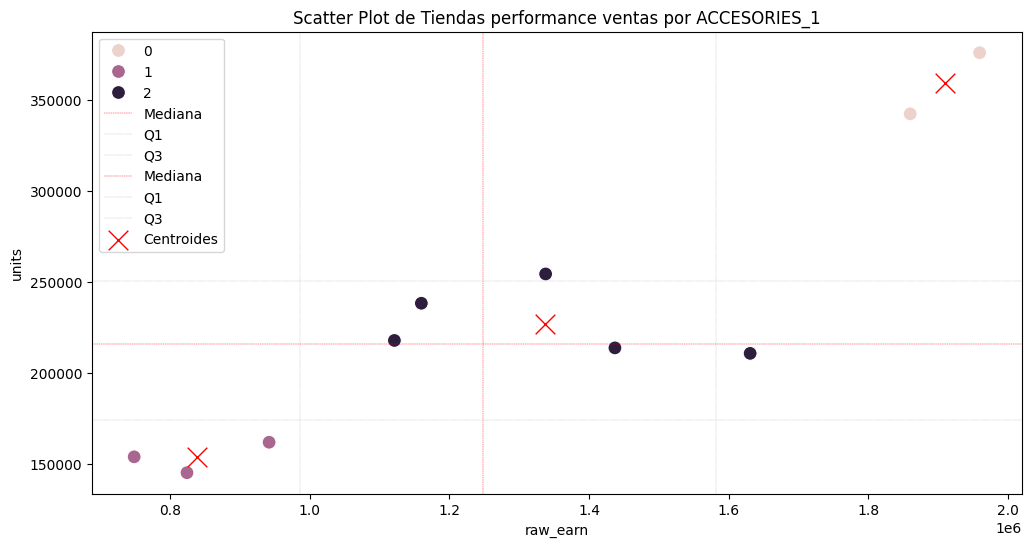

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Departamento: ACCESORIES_2
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


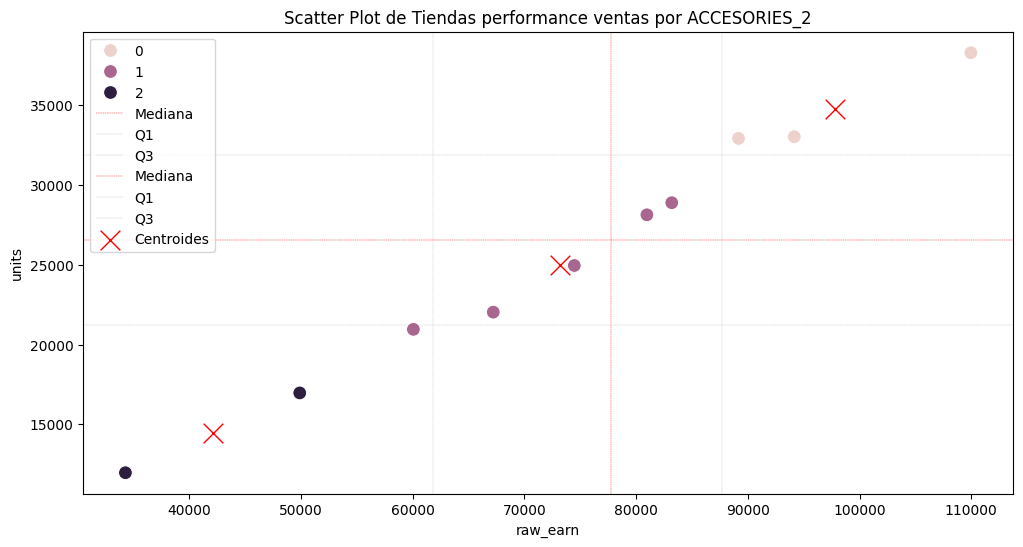

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Departamento: HOME_&_GARDEN_1
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


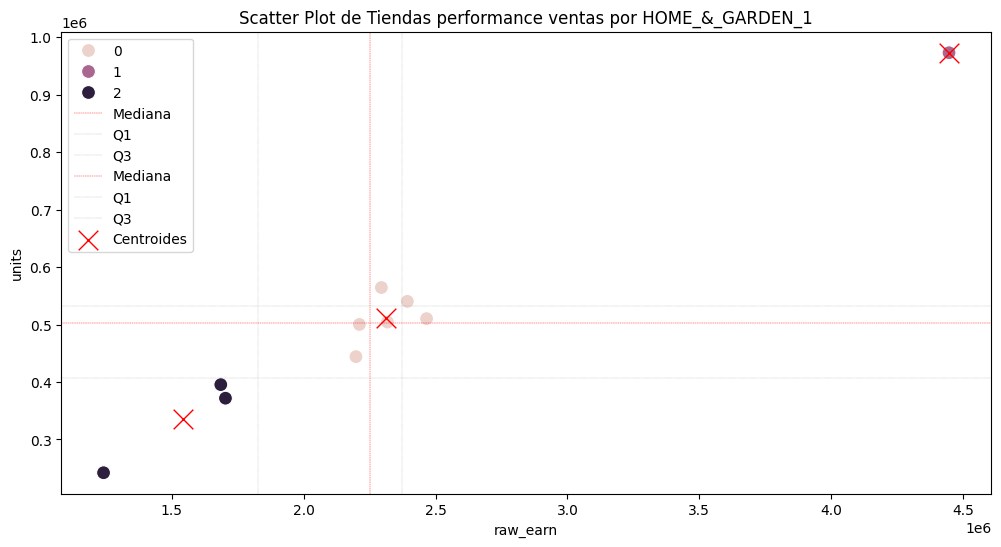

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Departamento: HOME_&_GARDEN_2
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


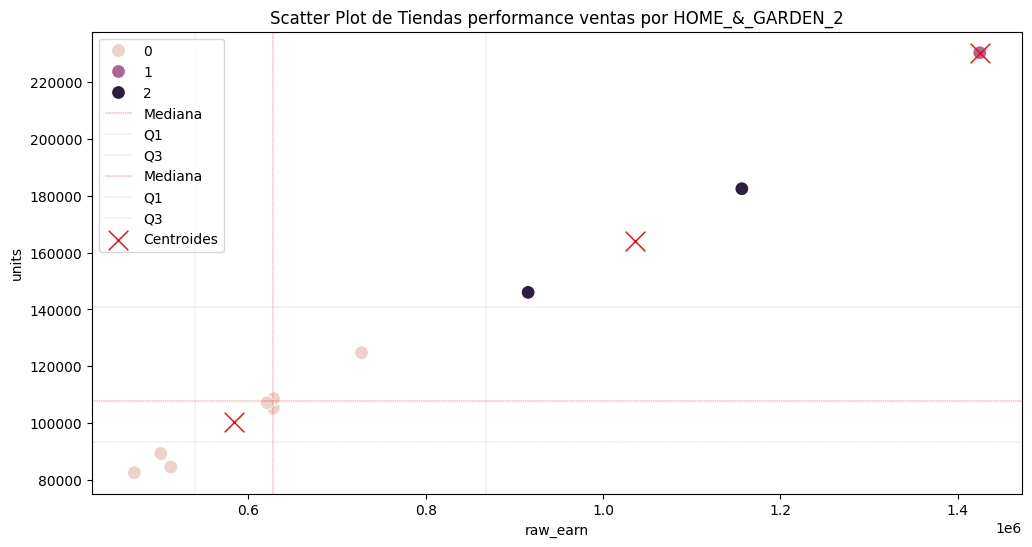

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Departamento: SUPERMARKET_1
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


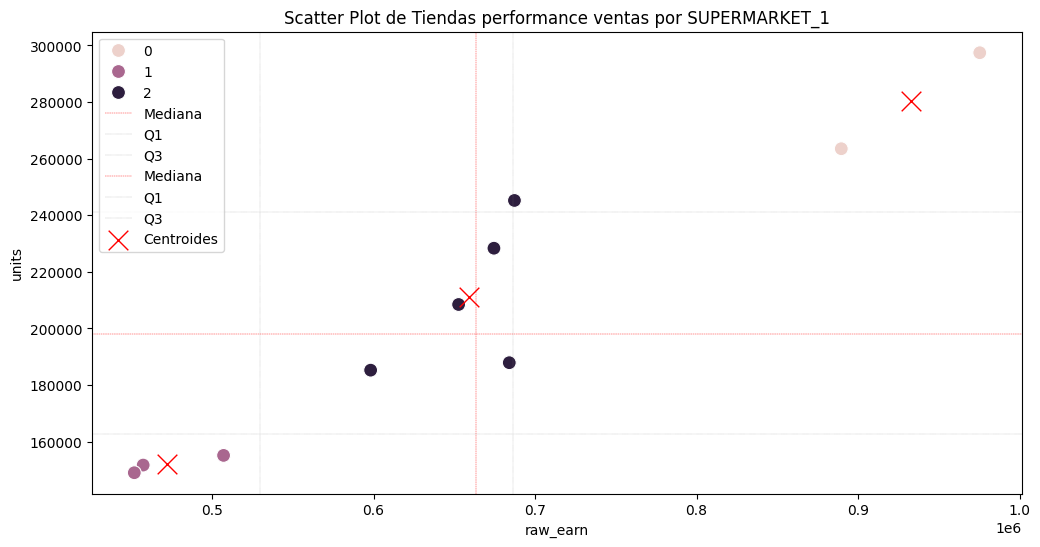

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Departamento: SUPERMARKET_2
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


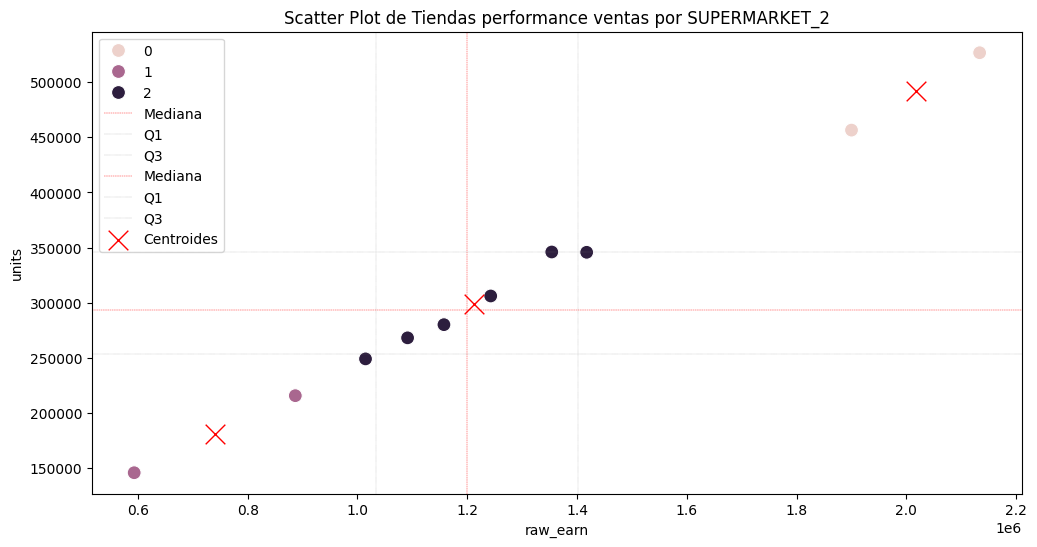

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Departamento: SUPERMARKET_3
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


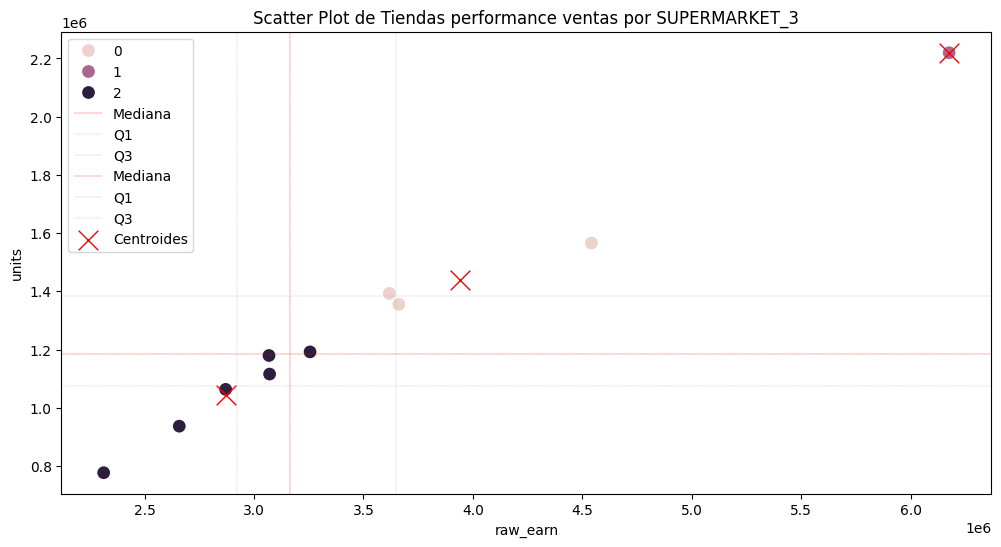

In [105]:
depts = df_['department'].unique().tolist()
optimal_k = 3 # Difiere en varios casos pero como Tribeca siempre esta on top vamos a mantener 3 a ver que sucede

for dept in depts:
  d = df_[df_['department'] == dept]
  print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
  print(f'Departamento: {dept}')
  print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
  d_scaled, scaler = preprocess_features(d[['units', 'raw_earn']])
  d_scaled, centroids, data_origin, model = k_means_categoria(d_scaled, d, optimal_k)
  plot_kmeans_category(data_origin, dept, model)

# PENDING:
- Asignar descripciones a clusters
- Añadir a df de shops

# ::::::::::::::::::::::::::::::::::::::::::::::

# Guardar CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_global_sales_performance.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# shops_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>